# Visualize Real and Synthetic Data on Sine Wave Dataset

This script provides the visual analysis of the synthetic time-series generator. There are seven ways to do analysis:
- **Diversity Assessment:** The distribution of the synthetic samples should roughly match that of the real data. We want to see how closely the distribution of the synthetic data resembels that of the original data
    - PCA Visualization.
    - T-SNE Visualization.
- **Fidelity Assessment:** The sample series should be indistinguishable from the real data. 
    - Real/Synthetic Data Classification.
- **Usefulness:** The synthetic data should be as useful as its real counterparts for solving the predictive task. We compare the test errors of a sequence prediction model trained on real or synthetic data to predict the next time step for real data
    - Train on Real, Test on Real (TRTR)
    - Train on Real, Test on Synthetic (TRTS)
    - Train on Synthetic, Test on Real (TSTR)
    - Train on Synthetic, Test on Synthetic (TSTS)
- **Additionally:** Correlation check between synthetic and real 24-row window dataset.

In [1]:
# Expand views
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Basic imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

2022-05-02 14:41:07.311814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 14:41:07.311845: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# Set GPU/CPU
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


2022-05-02 14:41:08.909619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-02 14:41:08.909667: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-02 14:41:08.909692: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist


In [4]:
# Set Seaborn Mode
sns.set_style('white')

In [5]:
results_path = Path('../../results')
if not results_path.exists():
    results_path.mkdir()

In [6]:
seq_len = 24
n_seq = 1

## Load Data

In [7]:
experiment = 2

In [8]:
df = pd.read_csv("../../../../../data/sine_wave.csv")

In [9]:
# Get only float values
df = df[['Sine']]

In [10]:
features = list(df.columns)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)
real_data = []
for i in range(len(df) - seq_len):
    real_data.append(scaled_data[i:i + seq_len])

In [11]:
np.asarray(real_data).shape

(4977, 24, 1)

In [12]:
# Import synthetic data
synthetic_data = np.load(results_path / f'experiment_{experiment:02d}' / 'generated_data_sine.npy')
synthetic_data.shape

(4864, 24, 1)

In [13]:
# Reshape the real data to have the same shape as the synthetic data
real_data = real_data[:synthetic_data.shape[0]]
np.asarray(real_data).shape

(4864, 24, 1)

## Prepare Sample

In [14]:
# Get 250 time points randomly
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [15]:
# Get 250 data points of each attributes each with the batch size of 24
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [16]:
# Reshape 3D (batch_size, feature_size ,window_size) to (batch_size * feature_size, window_size)
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [17]:
# Make sure real and synthetic datasets have the same shape
real_sample_2d.shape, synthetic_sample_2d.shape

((250, 24), (250, 24))

## 1. Diversity Test: Visualize Data in 2D
We will visualize the syntthetic and real series with 24 time steps and n number of features. PCA and TSNE, as doing dimension reduction, will help us plot in 2D. 

### 1.1. PCA

In-short, PCA is a linear method that identifies a new basis with mutually orthogonal vector that successively capture the directions of maximum variance in the data. We will compute the top two compoenents with real data then project both real and synthetic samples to new coordinate.

In [18]:
pca = PCA(n_components=2) # 2D 
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d)).assign(Data="Real"))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d)).assign(Data="Synthetic"))
pca_result = pca_real.append(pca_synthetic).rename(columns={0: '1st Component', 1: '2nd Component'})

### 1.2. t-SNE
In-short, T-SNE is a non-linear manifold learning method for the visualization of high-dimensionnal data. T-SNE converts similarities between data points to joint probabilities and aim to minnimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

In [19]:
tsne_data = np.concatenate((real_sample_2d, synthetic_sample_2d), axis=0)
tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

/home/mnguyen0226/anaconda3/envs/mtss_gan2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/mnguyen0226/anaconda3/envs/mtss_gan2/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.231106
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.680389
[t-SNE] KL divergence after 1000 iterations: 0.133682


In [20]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*26:, 'Data'] = 'Synthetic'

## 1.3. Plot Results

There are not much diversity but we can see that the synthetic data can capture the trend of the original dataset.

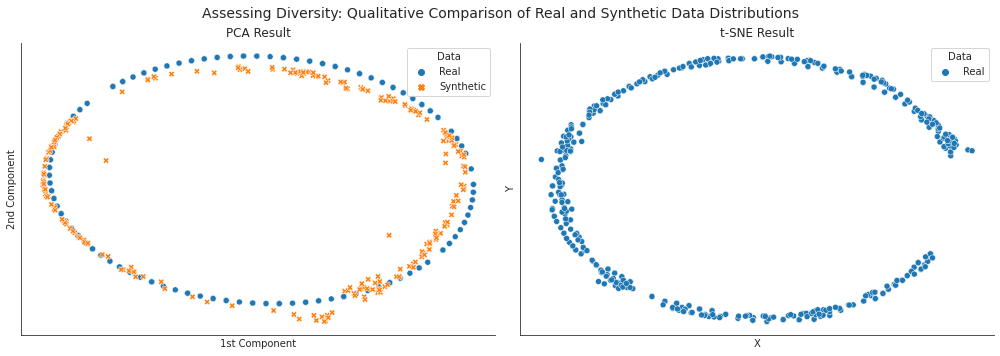

In [76]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0])
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data', 
                style='Data', 
                ax=axes[1])
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);
plt.savefig('../../../../imgs/sine_visual.png')

# 2. Fidelity Test: Time Series Classification 
 
A quantitative assessment of Fidelity. We label each batch sample as either real or synthetic, then we train a classifier accordingly to see if it can distinguish between real or synthetic data. The lower the testing accuracy, the better it is. The train-test-split is 80% / 20% accordingly.


## 2.1. Prepare Data

In [22]:
real_data = np.array(real_data)[:len(synthetic_data)]
real_data.shape

(4864, 24, 1)

In [23]:
synthetic_data.shape

(4864, 24, 1)

In [24]:
n_series = real_data.shape[0]
n_series

4864

In [25]:
idx = np.arange(n_series)
idx

array([   0,    1,    2, ..., 4861, 4862, 4863])

In [26]:
# Use 80% Training and 20% Testing
n_train = int(.8*n_series) 
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [27]:
# Stacks the real and synthetic samples on top of each other
train_data = np.vstack((real_data[train_idx], 
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], 
                       synthetic_data[test_idx]))

In [28]:
train_data.shape

(7782, 24, 1)

In [29]:
test_data.shape

(1946, 24, 1)

In [30]:
# Create labels: 1 is real, 0 is synthetic
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

## 2.2. Create Classifier

Evaluate whether real and synthetic time series can be differentiated or are indistinguishable.

In [31]:
ts_classifier = Sequential([GRU(6, input_shape=(24, 1), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

2022-05-02 14:41:12.215096: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [33]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 6)                 162       
                                                                 
 OUT (Dense)                 (None, 1)                 7         
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________


In [34]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=250,
                           batch_size=128,
                           verbose=0)

In [35]:
ts_classifier.evaluate(x=test_data, y=test_labels)

61/61 [==============================] - 0s 3ms/step - loss: 0.3999 - AUC: 0.8960 - accuracy: 0.7980


[0.3999089002609253, 0.895990252494812, 0.7980473041534424]

In [36]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


In [37]:
from matplotlib.ticker import FuncFormatter

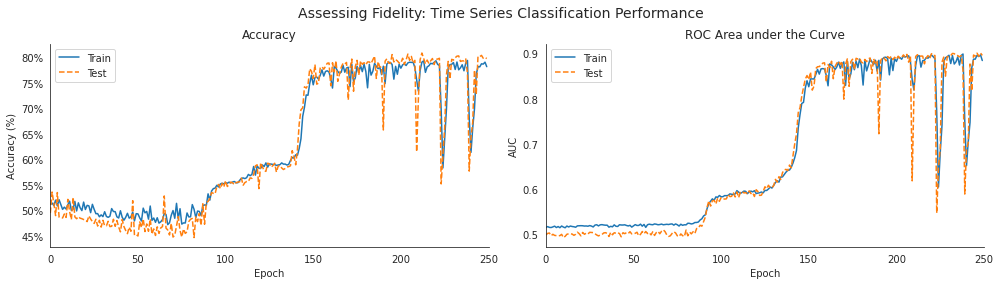

In [38]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

Here we can see that the AUC is 100% and the test accuracy is 100% and the plot shows accordingly. This means that the model was able to learn the difference between the real and synthetic data in a way that generalizes to the test set.

# 3. Usefulness Tests
There will be 4 different tests: 
- Train on Real, Test on Real **(TRTR)**: check the classifier.
- Train on Real, Test on Synthetic **(TRTS)**: check if the 2 Synthetic can fool the classifier.
- Train on Synthetic, Test on Real **(TSTR)**: check if we can replace the Real for Synthetic in the training process.
- Train on Synthetic, Test on Synthetic **(TSTS)**: check if we can replace the real dataset entirely.

The main idea is that we will take in a window and try to predict the next time step. We will use the same model for all 4 tests.

In [56]:
def get_model():
    model = Sequential([GRU(6, input_shape=(seq_len-1, n_seq)),
                        Dense(1)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

In [57]:
real_data = real_data
real_data = np.array(real_data)

In [58]:
real_data.shape

(4864, 24, 1)

In [59]:
n_series = real_data.shape[0]
idx = np.arange(n_series)

# train-test split is 80% 20%

n_train = int(.8*n_series) 
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [60]:
len(train_idx), len(test_idx)

(3891, 973)

In [61]:
# Split real data to train-test
real_train_data = real_data[train_idx, :23, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :23, :]
real_test_label = real_data[test_idx, -1, :]

In [62]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((3891, 23, 1), (3891, 1), (973, 23, 1), (973, 1))

In [63]:
# Split Real Data
synthetic_train_data = synthetic_data[train_idx, :23, :]
synthetic_train_label = synthetic_data[train_idx, -1, :]

synthetic_test_data = synthetic_data[test_idx, :23, :]
synthetic_test_label = synthetic_data[test_idx, -1, :]

In [64]:
synthetic_train_data.shape, synthetic_train_label.shape, synthetic_test_data.shape , synthetic_test_label.shape

((3891, 23, 1), (3891, 1), (973, 23, 1), (973, 1))

In [65]:
full_synthetic_train = synthetic_data[:, :23, :]
full_synthetic_label = synthetic_data[:, -1, :]

In [66]:
full_synthetic_train.shape, full_synthetic_label.shape

((4864, 23, 1), (4864, 1))

In [67]:
full_real_train = real_data[:, :23, :]
full_real_label = real_data[:, -1, :]

In [68]:
full_real_train.shape, full_real_label.shape

((4864, 23, 1), (4864, 1))

## 3.1. Train on Real, Test on Real

In [69]:
ts_regression = get_model()
trtr_result = ts_regression.fit(x=real_train_data,
                                     y=real_train_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

## 3.2. Train on Full Real, Test on Test Synthetic

In [70]:
ts_regression = get_model()
trts_result = ts_regression.fit(x=full_real_train,
                                     y=full_real_label,
                                     validation_data=(
                                         synthetic_test_data, 
                                         synthetic_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

## 3.3. Train on Full Synthetic, Test on Test Real

In [71]:
ts_regression = get_model()
tstr_result = ts_regression.fit(x=full_synthetic_train,
                                     y=full_synthetic_label,
                                     validation_data=(
                                         real_test_data, 
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

## 3.4. Train on Synthetic, Test on Test Synthetic

In [72]:
ts_regression = get_model()
tsts_result = ts_regression.fit(x=synthetic_train_data,
                                     y=synthetic_train_label,
                                     validation_data=(
                                         synthetic_test_data, 
                                         synthetic_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

## 3.5. Plot Results

In [73]:
trtr_result = pd.DataFrame(trtr_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
trts_result = pd.DataFrame(trts_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
tstr_result = pd.DataFrame(tstr_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
tsts_result = pd.DataFrame(tsts_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

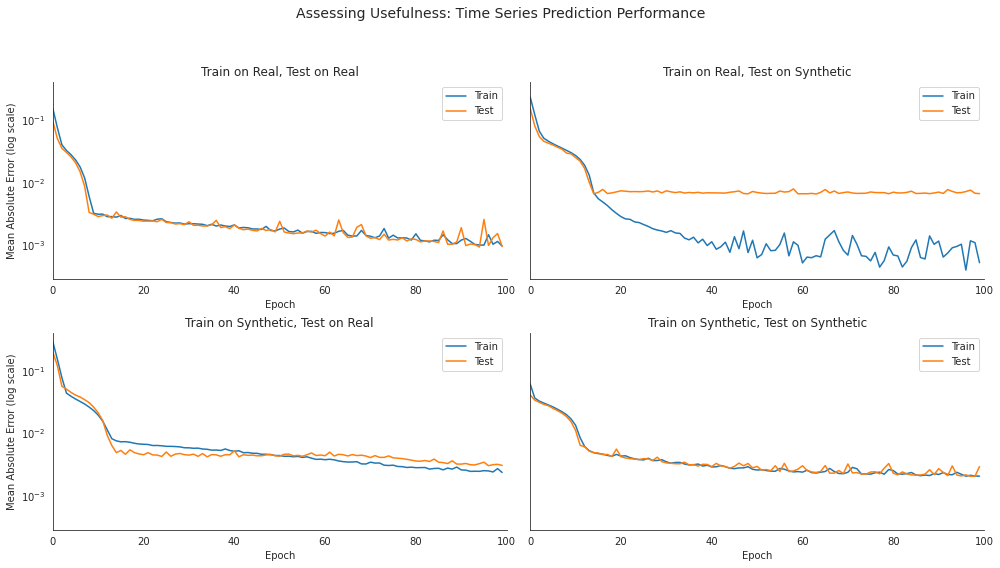

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), sharey=True)
axes = axes.flatten()

trtr_result.plot(ax=axes[0], title='Train on Real, Test on Real', logy=True, xlim=(0, 100))
trts_result.plot(ax=axes[1], title='Train on Real, Test on Synthetic', logy=True, xlim=(0, 100))
tstr_result.plot(ax=axes[2], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, 100))
tsts_result.plot(ax=axes[3], title='Train on Synthetic, Test on Synthetic', logy=True, xlim=(0, 100))
for i in [0, 1, 2, 3]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

We can see that the synthetic training or testing data is useful. On a predictive task of the next hour performance of the cyber-physical systems, as simple model train/test on synthetic TimeGAN data delivers similar performance than training on real.